# Imported Libraries

In [98]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score,accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from aif360.metrics import ClassificationMetric
from aif360.datasets import BinaryLabelDataset
from sklearn.model_selection import GridSearchCV

import helpers

# Helper Functions

In [99]:
features = ['Weight', 'Body mass index', 'Systolic', 'Diastolic', 'Gender', 'Age',
       'Glycohemoglobin', 'Cholesterol', 'High-density lipoprotein (HDL)',
       'Albumin', 'Alanine aminotransferase (ALT)',
       'Aspartate aminotransferase (AST)', 'Alkaline phosphatase (ALP)',
       'Gamma-glutamyl transferase (GGT)', 'Glucose', 'Iron',
       'Lactate dehydrogenase (LDH)', 'Phosphorus', 'Bilirubin', 'Protein',
       'Triglycerides', 'Uric acid', 'Creatinine', 'White blood cells',
       'Basophils', 'Red blood cells', 'Hemoglobin', 'Red blood cell width',
       'Platelet count', 'Mean volume of platelets', 'Moderate-work',
       "Diabetes_Don't know", 'Diabetes_No', 'Diabetes_Yes', 'Blood related diabetes_No',
       'Blood related diabetes_Refused', 'Blood related diabetes_Yes',
       'Vigorous-work_No', 'Vigorous-work_Refused',
       'Vigorous-work_Unable to do activity', 'Vigorous-work_Yes']

In [100]:
def process_and_load_data(data = pd.DataFrame, target = str):
    #The input should only be a Pandas DataFrame 
 
    #This creates split datasets for training, testing, and validation
    #Additionally it prepares the input data sets for model fitting and predicting
    X = data.drop(target, axis = 1)
    y = data[target]
   
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    # #Gender Indeces for Gender Assessment
    # gender_indeces = {'testing':{'Male':X_test[X_test['Gender'] == 1].index, 'Female':X_test[X_test['Gender'] == 0].index}, 
    #                   'Validtion':{'Male': X_val[X_val['Gender'] == 1].index, 'Female': X_val[X_val['Gender'] == 0].index}}

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_val =  scaler.transform(X_val)

    return X_train, X_test, X_val, y_train, y_test, y_val
    


In [101]:
def model_assessment(predictions, actuals):
    
   

    #Overall
    overall_accuracy = accuracy_score(actuals, predictions)
    overall_recall = recall_score(actuals, predictions)
    overall_precision = precision_score(actuals, predictions)

    #Male
    


    #Female


    results = pd.DataFrame({
        'Group': ['Overall'],
        'Accuracy': [overall_accuracy],
        'Recall': [overall_recall],
        'Precision': [overall_precision]
    })

    return results

In [102]:
def thresholds_assessment(raw_predictions, actuals, thresholds = list):
    accs =[]
    recalls = []
    precs = []
    for threshold in thresholds:
        new_preds = (raw_predictions >= threshold).astype(int)
        accs.append(accuracy_score(actuals, new_preds))
        recalls.append(recall_score(actuals, new_preds))
        precs.append(precision_score(actuals, new_preds))
    return {'Accuracy': accs, 'Recall': recalls, 'Precision': precs}

In [103]:
def fairness_metrics(input_df, predictions):

    binary_dataset = BinaryLabelDataset(df=input_df, 
                                    label_names=['Coronary heart disease'], 
                                    protected_attribute_names=['Gender'])

    # Create predictions dataset
    pred_df = input_df.drop('Coronary heart disease', axis = 1)
    pred_df['Coronary heart disease'] = predictions
    binary_predictions = BinaryLabelDataset(df=pred_df, 
                                            label_names=['Coronary heart disease'], 
                                            protected_attribute_names=['Gender'])

    # Compute metrics
    metric = ClassificationMetric(binary_dataset, binary_predictions, 
                                unprivileged_groups=[{'Gender': 0}], 
                                privileged_groups=[{'Gender': 1}]) 
    
    demographic_parity_difference = metric.statistical_parity_difference()
    equal_opportunity_difference = metric.equal_opportunity_difference()
    predictive_parity = metric.statistical_parity_difference()
    disparate_impact = metric.disparate_impact()


    #Output Metrics in a Pandas DataFrame
    fairness_table = pd.DataFrame({
        'Metric': ['Demographic Parity Difference', 'Equal Opportunity Difference',
                   'Predictive Parity', 'Disparate Impact'],
        'Value': [demographic_parity_difference, equal_opportunity_difference,
                  predictive_parity, disparate_impact]
    })

    return fairness_table

# Data Load & Processing

In [104]:
df = pd.read_parquet('data/nhanes_data_processed.parquet')
df.head()

,Weight,Body mass index,Systolic,Diastolic,Gender,Age,Diabetes,Glycohemoglobin,Cholesterol,High-density lipoprotein (HDL),...,Basophils,Red blood cells,Hemoglobin,Red blood cell width,Platelet count,Mean volume of platelets,Coronary heart disease,Blood related diabetes,Moderate-work,Vigorous-work
4,92.5,29.10,122.0,82.0,Male,597.0,No,5.5,7.21,1.08,...,5.397605e-79,5.13,14.5,13.1,209.0,10.4,No,No,17.0,Yes
6,78.0,29.39,130.0,78.0,Female,712.0,No,5.8,6.34,2.73,...,5.397605e-79,4.60,13.4,14.3,244.0,8.2,No,Yes,3.0,No
9,111.8,30.94,152.0,98.0,Male,518.0,No,5.5,3.62,1.31,...,5.397605e-79,5.00,15.4,13.7,167.0,9.4,No,Don't know,13.0,Don't know
13,75.5,27.33,142.0,56.0,Male,973.0,No,5.8,4.50,1.04,...,5.397605e-79,5.32,16.6,12.4,160.0,9.0,No,No,9.0,Yes
14,81.6,26.68,106.0,68.0,Female,459.0,No,4.6,5.15,1.49,...,5.397605e-79,4.14,13.3,11.9,255.0,7.7,No,No,13.0,Yes


### One Hot Encode the Categorical Features

In [105]:
# Male = 1
# Female = 0
# CHD Positive = 1
# CHD Negative = 1
df['Gender'] = df['Gender'].mask(df['Gender'] == 'Male', 1).mask(df['Gender'] == 'Female', 0)
df['Coronary heart disease'] = df['Coronary heart disease'].mask(df['Coronary heart disease'] == 'Yes', 1).mask(df['Coronary heart disease'] == 'No', 0)
categorical_cols = ['Diabetes', 'Blood related diabetes', 'Vigorous-work']

# One-hot encoding
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Data Type Corrects
df['Coronary heart disease'] = df['Coronary heart disease'].astype(int)

### Create Train/Test/Validation Sets

In [106]:
X_train, X_test, X_val, y_train, y_test, y_val = process_and_load_data(df, 'Coronary heart disease')

# Base Logistic Regression Model

In [107]:

log_reg = sklearn.linear_model.LogisticRegression(class_weight="balanced", max_iter = 100)

In [108]:
log_reg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

### Default Threshold of 0.5

In [109]:
y_pred = log_reg.predict(X_test)

In [110]:
y_pred = log_reg.predict(X_test)
helpers.model_assessment(y_pred, y_test)

,Group,Accuracy,Recall,Precision,Balanced Accuracy
0,Overall,0.76124,0.738544,0.115856,0.750371


### Testing with Different Thresholds

### Validation Set

In [111]:
y_pred_proba = log_reg.predict_proba(X_val)[:, 1]

In [112]:
thresholds = np.arange(0.1, 1, 0.1)
metrics = thresholds_assessment(y_pred_proba, y_test, thresholds)

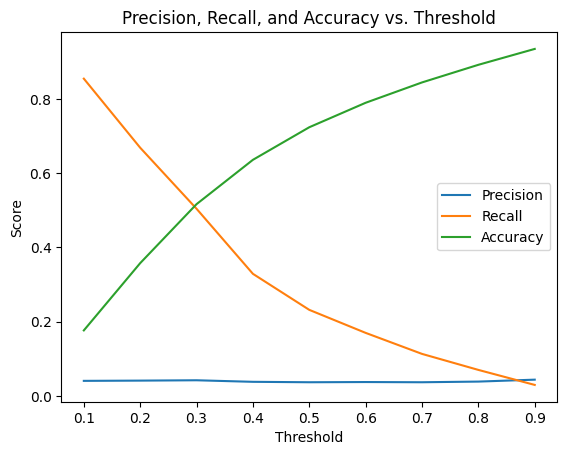

In [113]:
plt.plot(thresholds, metrics['Precision'], label='Precision')
plt.plot(thresholds, metrics['Recall'], label='Recall')
plt.plot(thresholds, metrics['Accuracy'], label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and Accuracy vs. Threshold')
plt.legend()
plt.show()

### F1-Score Evaluation

In [114]:
f1_scores = []
for t in thresholds:
    preds = (y_pred_proba  >= t).astype(int)
    f1 = f1_score(y_val, preds)
    f1_scores.append(f1)

optimal_threshold = thresholds[f1_scores.index(max(f1_scores))]
print(f"Optimal threshold for F1-Score: {optimal_threshold}")

Optimal threshold for F1-Score: 0.7000000000000001


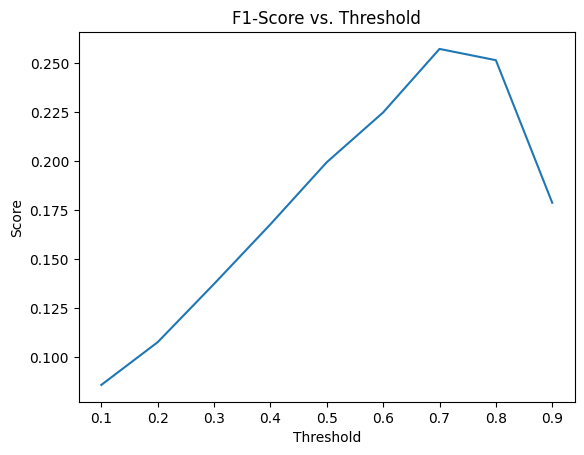

In [115]:
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('F1-Score vs. Threshold')
plt.show()

In [116]:
preds = (y_pred_proba >= 0.7).astype(int)

In [117]:
helpers.model_assessment(preds, y_val)

,Group,Accuracy,Recall,Precision,Balanced Accuracy
0,Overall,0.878983,0.543909,0.168421,0.718158


# Fairness Assessment

In [118]:
y_pred = log_reg.predict(X_val)

In [119]:

X_train, X_test= train_test_split(df, test_size=0.2, random_state=42)
X_train, X_val = train_test_split(X_train, test_size=0.25, random_state=42)
fairness_metrics(X_val, y_pred)

,Metric,Value
0,Demographic Parity Difference,-0.187603
1,Equal Opportunity Difference,-0.240913
2,Predictive Parity,-0.187603
3,Disparate Impact,0.466035
